### Question
Does this network produces Symmetrical Weights?

![Symmetry](screenshots/symmetrical_weights.png)

In [136]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
import math
from jax.scipy.special import logsumexp
from jax.nn import sigmoid
import jax

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(network_sizes, scale=1e-2):
  key =  random.PRNGKey(0)
  keys = random.split(key, len(network_sizes))
  return [
     random_layer_params(in_out[0], in_out[1], k, scale) for in_out, k in zip(network_sizes, keys)]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')

In [137]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, X):
    activations = X 
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return logits
    # return outputs

    # return jnp.tanh(logits)

@jit
def loss_func(params, X_train, y_train):
  preds = predict(params, X_train)
  return mse(preds, y_train)

In [138]:
import numpy as np

def generate_data(num_sample):
  seed = np.random.randint(0, 1024)
  key =  jax.random.PRNGKey(seed)
  key, subkey = jax.random.split(key)
  # X_train = jax.random.uniform(subkey, minval=-1.0, maxval=1.0, shape=(num_sample,1), dtype=jnp.float32)
  X_train = jnp.linspace(-1.0, 1.0, num_sample).reshape(-1,1)
  return X_train

def update_weights(params, X, y, step_size):
  grads = grad(loss_func)(params, X, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_sample, num_epochs, step_size, step_display, current_round):
  for curr_epoch in range(1, num_epochs + 1):
    X_train = generate_data(num_sample)

    loss = loss_func(params, X_train, X_train)
    params = update_weights(params, X_train, X_train, step_size)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params, current_round + 1

In [139]:
num_sample = 100
key =  jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
X_train = jax.random.normal(subkey, shape=(num_sample,1), dtype=jnp.float32)

print(jnp.min(X_train))
print(jnp.max(X_train))
print(X_train.mean())
print(X_train.std())

-2.8795924
3.086006
0.28034323
1.0274636


[10/3000] Loss: 0.3339933753013611
[20/3000] Loss: 0.3339930772781372
[30/3000] Loss: 0.33399274945259094
[40/3000] Loss: 0.33399245142936707
[50/3000] Loss: 0.3339921534061432
[60/3000] Loss: 0.3339918851852417
[70/3000] Loss: 0.3339915871620178
[80/3000] Loss: 0.33399131894111633
[90/3000] Loss: 0.3339911103248596
[100/3000] Loss: 0.3339908719062805
[110/3000] Loss: 0.3339906334877014
[120/3000] Loss: 0.3339903950691223
[130/3000] Loss: 0.3339901864528656
[140/3000] Loss: 0.3339899778366089
[150/3000] Loss: 0.33398979902267456
[160/3000] Loss: 0.33398959040641785
[170/3000] Loss: 0.3339894413948059
[180/3000] Loss: 0.3339892625808716
[190/3000] Loss: 0.33398908376693726
[200/3000] Loss: 0.33398890495300293
[210/3000] Loss: 0.3339887857437134
[220/3000] Loss: 0.33398863673210144
[230/3000] Loss: 0.3339884877204895
[240/3000] Loss: 0.33398833870887756
[250/3000] Loss: 0.3339881896972656
[260/3000] Loss: 0.33398810029029846
[270/3000] Loss: 0.3339879512786865
[280/3000] Loss: 0.33398783

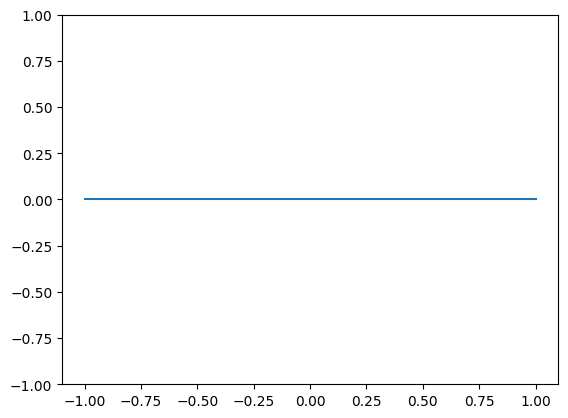

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.color_palette('muted')
num_hidden = 3

network_sizes = [
    (1, num_hidden),    # First Layer 
    (num_hidden, 1),    # Second Layer
    (1, num_hidden),    # Third Layer
    (num_hidden, 1),    # Fourth Layer 
]

num_sample = 2**10
num_epochs = 3000
step_size = 0.001
step_display = 10
current_round = 1

key =  jax.random.PRNGKey(0)
params = init_network_params(network_sizes)
params, current_round = train_network(params, num_sample, num_epochs, step_size, step_display, current_round)
X_test = jnp.linspace(-1.0, 1.0, num=1024).reshape(-1,1)
y_pred = predict(params, X_test)

plt.plot(X_test.reshape(-1), y_pred.reshape(-1))
plt.ylim(-1.0, 1.0)
plt.show()

In [126]:
print(params)

[(Array([[-5.4082624e-03,  6.1440143e-05,  5.2159280e-03]], dtype=float32), Array([-0.00297437,  0.02615191, -0.00030386], dtype=float32)), (Array([[-0.00644542],
       [-0.01944787],
       [ 0.00159121]], dtype=float32), Array([0.00949058], dtype=float32)), (Array([[-0.01932771, -0.00165951,  0.00215066]], dtype=float32), Array([-0.0212311 , -0.01765462, -0.0002006 ], dtype=float32)), (Array([[-0.01055277],
       [ 0.00073849],
       [ 0.02148872]], dtype=float32), Array([0.00294655], dtype=float32))]


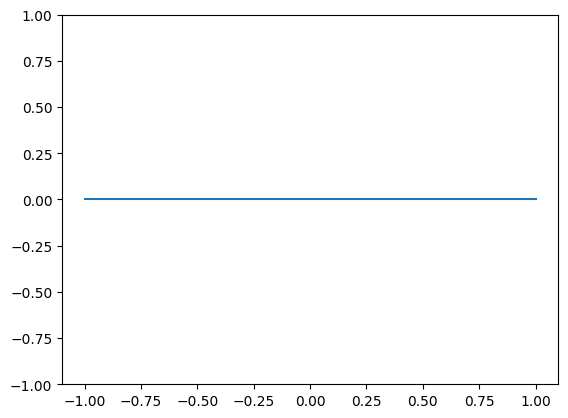

### What's obvious
- Instead of reconstructing X, the loss function takes an easy way by learning how to predict the mean which is zero. 

[10/3000] Loss: 0.33326756954193115
[20/3000] Loss: 0.31874334812164307
[30/3000] Loss: 0.34742170572280884
[40/3000] Loss: 0.33600932359695435
[50/3000] Loss: 0.3361687660217285
[60/3000] Loss: 0.3392399251461029
[70/3000] Loss: 0.3351781964302063
[80/3000] Loss: 0.3532862067222595
[90/3000] Loss: 0.33446380496025085
[100/3000] Loss: 0.3253321647644043
[110/3000] Loss: 0.33823418617248535
[120/3000] Loss: 0.3368671238422394
[130/3000] Loss: 0.33327949047088623
[140/3000] Loss: 0.3175184726715088
[150/3000] Loss: 0.3367452621459961
[160/3000] Loss: 0.3150898218154907
[170/3000] Loss: 0.33542799949645996
[180/3000] Loss: 0.33074402809143066
[190/3000] Loss: 0.3246009349822998
[200/3000] Loss: 0.32752370834350586
[210/3000] Loss: 0.32931870222091675
[220/3000] Loss: 0.34350964426994324
[230/3000] Loss: 0.31600022315979004
[240/3000] Loss: 0.3481670618057251
[250/3000] Loss: 0.33821624517440796
[260/3000] Loss: 0.32745561003685
[270/3000] Loss: 0.3421439230442047
[280/3000] Loss: 0.346188

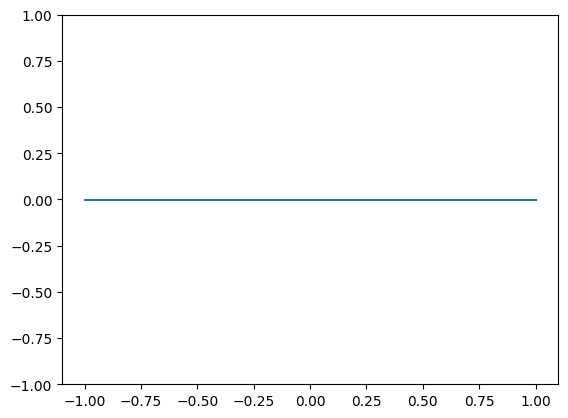

In [113]:
sns.color_palette('muted')
num_hidden = 3

network_sizes = [
    (1, num_hidden),    # First Layer 
    (num_hidden, 2 * num_hidden),    # Second Layer
    (2 * num_hidden, num_hidden),    # Third Layer
    (num_hidden, 1),    # Fourth Layer 
]

num_sample = 2**10
num_epochs = 3000
step_size = 0.001
step_display = 10
current_round = 1

key =  jax.random.PRNGKey(0)
params = init_network_params(network_sizes)
params, current_round = train_network(params, num_sample, num_epochs, step_size, step_display, current_round)
X_test = jnp.linspace(-1.0, 1.0, num=1024).reshape(-1,1)

y_pred = predict(params, X_test)

plt.plot(X_test.reshape(-1), y_pred.reshape(-1))
plt.ylim(-1.0, 1.0)
plt.show()


### Additional Notes
- It's actually hard for the Neural Network to learn the identity function. It's actually a well known fact from practitioners.

In [98]:
for param in params:
    print(param)

(Array([[-5.4082624e-03,  6.1440143e-05,  5.2159280e-03]], dtype=float32), Array([-0.00297437,  0.02615191, -0.00030386], dtype=float32))
(Array([[-0.00644542],
       [-0.01944787],
       [ 0.00159121]], dtype=float32), Array([0.00949058], dtype=float32))
(Array([[-0.01932771, -0.00165951,  0.00215066]], dtype=float32), Array([-0.0212311 , -0.01765462, -0.0002006 ], dtype=float32))
(Array([[-0.01055277],
       [ 0.00073849],
       [ 0.02148872]], dtype=float32), Array([-0.00054771], dtype=float32))
